<a href="https://colab.research.google.com/github/cwjng/si671-final-project/blob/main/Notebook_Cho_Lee_Ng.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer Clustering & Correlation Analysis Notebook

SI 671 Data Mining, December 9, 2025

Hailey Cho, Adia Lee, Christina Ng

This notebook builds the clustering component for the SI 671 final project by preparing the e-commerce dataset, training clustering models, running correlation and regression analyses, and summarizing insights.

## Data Description

This dataset comes from ***Ecommerce Consumer Behavior Analysis Data* via. Kaggle***. This dataset captures key aspects of consumer behavior and purchasing decisions. It includes demographic details, shopping habits, product evaluations, discount sensitivity, advertising engagement, and customer satisfaction—making it useful for market segmentation, predictive modeling, and understanding what drives customer choices.

The dataset has 28 columns. Here's a general breakdown of each column, seperated by general categories:

* **Unique customer identifier** – Customer_ID
* **Demographic attributes** – Age, Gender, Income_Level, Marital_Status, Education_Level, Occupation, Location
* **Purchasing behavior** – Purchase_Category, Purchase_Amount, Frequency_of_Purchase, Purchase_Channel
* **Attitudes and feedback** – Brand_Loyalty, Product_Rating, Customer_Satisfaction
* **Research & marketing exposure** – Time_Spent_on_Product_Research, Social_Media_Influence, Engagement_with_Ads
* **Price responsiveness** – Discount_Sensitivity, Discount_Used
* **Product return frequency** – Return_Rate
* **Loyalty program membership** – Customer_Loyalty_Program_Member
* **Shopping and payment preferences** – Device_Used_for_Shopping, Payment_Method, Payment_Frequency
* **Timing-related attributes** – Time_of_Purchase, Time_to_Decision
* **Intent and fulfillment preferences** – Purchase_Intent, Shipping_Preference

In [241]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
from sklearn.compose import ColumnTransformer
from sklearn.metrics.pairwise import cosine_similarity

plt.style.use("seaborn-v0_8")

df_raw = pd.read_csv("si671-final-project/Ecommerce_Consumer_Behavior_Analysis_Data.csv")
print(f"Rows: {df_raw.shape[0]}, Columns: {df_raw.shape[1]}")
df_raw.head()

Rows: 1000, Columns: 28


,Customer_ID,Age,Gender,Income_Level,Marital_Status,Education_Level,Occupation,Location,Purchase_Category,Purchase_Amount,...,Customer_Satisfaction,Engagement_with_Ads,Device_Used_for_Shopping,Payment_Method,Time_of_Purchase,Discount_Used,Customer_Loyalty_Program_Member,Purchase_Intent,Shipping_Preference,Time_to_Decision
0,37-611-6911,22,Female,Middle,Married,Bachelor's,Middle,Évry,Gardening & Outdoors,$333.80,...,7,NaN,Tablet,Credit Card,3/1/2024,True,False,Need-based,No Preference,2
1,29-392-9296,49,Male,High,Married,High School,High,Huocheng,Food & Beverages,$222.22,...,5,High,Tablet,PayPal,4/16/2024,True,False,Wants-based,Standard,6
2,84-649-5117,24,Female,Middle,Single,Master's,High,Huzhen,Office Supplies,$426.22,...,7,Low,Smartphone,Debit Card,3/15/2024,True,True,Impulsive,No Preference,3
3,48-980-6078,29,Female,Middle,Single,Master's,Middle,Wiwilí,Home Appliances,$101.31,...,1,NaN,Smartphone,Other,10/4/2024,True,True,Need-based,Express,10
4,91-170-9072,33,Female,Middle,Widowed,High School,Middle,Nara,Furniture,$211.70,...,10,NaN,Smartphone,Debit Card,1/30/2024,False,False,Wants-based,No Preference,4


In [242]:
df = df_raw.copy()

# clean purchase amount
df["Purchase_Amount"] = (
    df["Purchase_Amount"]
    .replace({"\$": "", ",": ""}, regex=True)
    .str.strip()
    .astype(float)
)

# convert numeric
to_force_numeric = [
    "Age", "Frequency_of_Purchase", "Brand_Loyalty", "Product_Rating",
    "Time_Spent_on_Product_Research(hours)", "Return_Rate",
    "Customer_Satisfaction", "Time_to_Decision"
]

for col in to_force_numeric:
    df[col] = pd.to_numeric(df[col], errors="coerce")

<>:6: SyntaxWarning: invalid escape sequence '\$'
<>:6: SyntaxWarning: invalid escape sequence '\$'
/tmp/ipython-input-3480012805.py:6: SyntaxWarning: invalid escape sequence '\$'
  .replace({"\$": "", ",": ""}, regex=True)


In [243]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 28 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Customer_ID                            1000 non-null   object 
 1   Age                                    1000 non-null   int64  
 2   Gender                                 1000 non-null   object 
 3   Income_Level                           1000 non-null   object 
 4   Marital_Status                         1000 non-null   object 
 5   Education_Level                        1000 non-null   object 
 6   Occupation                             1000 non-null   object 
 7   Location                               1000 non-null   object 
 8   Purchase_Category                      1000 non-null   object 
 9   Purchase_Amount                        1000 non-null   float64
 10  Frequency_of_Purchase                  1000 non-null   int64  
 11  Purch

In [244]:
df.describe(include='all')

,Customer_ID,Age,Gender,Income_Level,Marital_Status,Education_Level,Occupation,Location,Purchase_Category,Purchase_Amount,...,Customer_Satisfaction,Engagement_with_Ads,Device_Used_for_Shopping,Payment_Method,Time_of_Purchase,Discount_Used,Customer_Loyalty_Program_Member,Purchase_Intent,Shipping_Preference,Time_to_Decision
count,1000,1000.000000,1000,1000,1000,1000,1000,1000,1000,1000.000000,...,1000.000000,744,1000,1000,1000,1000,1000,1000,1000,1000.000000
unique,1000,NaN,8,2,4,3,2,969,24,NaN,...,NaN,3,3,5,344,2,2,4,3,NaN
top,48-203-9118,NaN,Female,High,Widowed,Bachelor's,High,Oslo,Electronics,NaN,...,NaN,High,Desktop,PayPal,3/3/2024,True,False,Need-based,No Preference,NaN
freq,1,NaN,452,515,260,341,517,4,54,NaN,...,NaN,270,350,219,8,521,509,256,372,NaN
mean,NaN,34.304000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,275.063880,...,5.399000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.547000
std,NaN,9.353238,NaN,NaN,NaN,NaN,NaN,NaN,NaN,131.532998,...,2.868454,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.035849
min,NaN,18.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.710000,...,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
25%,NaN,26.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,162.235000,...,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.000000
50%,NaN,34.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,276.165000,...,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.000000
75%,NaN,42.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,388.982500,...,8.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.000000


# Customer Clustering Analysis

## Data Cleaning

## Feature Definition

In [245]:
numeric_features = [
    "Age","Purchase_Amount","Frequency_of_Purchase","Brand_Loyalty",
    "Product_Rating","Time_Spent_on_Product_Research(hours)",
    "Return_Rate","Customer_Satisfaction","Time_to_Decision",
]

categorical_features = [
    "Gender","Income_Level","Marital_Status","Occupation","Purchase_Category",
    "Purchase_Channel","Social_Media_Influence","Discount_Sensitivity",
    "Customer_Loyalty_Program_Member","Discount_Used","Purchase_Intent",
    "Shipping_Preference","Device_Used_for_Shopping","Payment_Method"
]

feature_df = df[numeric_features + categorical_features]
feature_df.head()

,Age,Purchase_Amount,Frequency_of_Purchase,Brand_Loyalty,Product_Rating,Time_Spent_on_Product_Research(hours),Return_Rate,Customer_Satisfaction,Time_to_Decision,Gender,...,Purchase_Category,Purchase_Channel,Social_Media_Influence,Discount_Sensitivity,Customer_Loyalty_Program_Member,Discount_Used,Purchase_Intent,Shipping_Preference,Device_Used_for_Shopping,Payment_Method
0,22,333.80,4,5,5,2.0,1,7,2,Female,...,Gardening & Outdoors,Mixed,NaN,Somewhat Sensitive,False,True,Need-based,No Preference,Tablet,Credit Card
1,49,222.22,11,3,1,2.0,1,5,6,Male,...,Food & Beverages,In-Store,Medium,Not Sensitive,False,True,Wants-based,Standard,Tablet,PayPal
2,24,426.22,2,5,5,0.3,1,7,3,Female,...,Office Supplies,Mixed,Low,Not Sensitive,True,True,Impulsive,No Preference,Smartphone,Debit Card
3,29,101.31,6,3,1,1.0,0,1,10,Female,...,Home Appliances,Mixed,High,Somewhat Sensitive,True,True,Need-based,Express,Smartphone,Other
4,33,211.70,6,3,4,0.0,2,10,4,Female,...,Furniture,Mixed,Medium,Not Sensitive,False,False,Wants-based,No Preference,Smartphone,Debit Card


## Preprocessing Pipeline

In [246]:
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

X = preprocessor.fit_transform(feature_df)
if hasattr(X, "toarray"):
    X = X.toarray()

feature_names = preprocessor.get_feature_names_out()
print(f"Transformed feature matrix shape: {X.shape}")

Transformed feature matrix shape: (1000, 77)


## Cluster Summary Function

In [247]:
df_clusters = df.copy()

representative_cats = [
    "Purchase_Channel", "Purchase_Intent", "Device_Used_for_Shopping",
    "Discount_Sensitivity", "Gender", "Income_Level", "Marital_Status",
    "Occupation", "Social_Media_Influence", "Discount_Used",
    "Payment_Method",
]

def mode_label(series: pd.Series):
    counts = series.value_counts()
    return counts.idxmax() if not counts.empty else np.nan

def summarize_clusters(label_col: str):
    numeric_summary = df_clusters.groupby(label_col)[numeric_features].mean().round(2)
    categorical_summary = df_clusters.groupby(label_col)[representative_cats].agg(mode_label)
    display(numeric_summary)
    display(categorical_summary)

In [248]:
# Embedding Visualization Helper
def plot_embedding_scatter(embedding: np.ndarray, labels: np.ndarray, title: str):
    plot_df = pd.DataFrame(embedding, columns=["Dim1", "Dim2"])
    plot_df["cluster"] = labels
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=plot_df,
        x="Dim1",
        y="Dim2",
        hue="cluster",
        palette="Set2",
        alpha=0.7,
    )
    plt.title(title)
    plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

## t-SNE Embedding + K-Means Clustering
Evaluate clustering performance across k = 2…8

In [249]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init="pca", random_state=42)
tsne_embedding = tsne.fit_transform(X)
print(f"t-SNE embedding shape: {tsne_embedding.shape}")

t-SNE embedding shape: (1000, 2)


In [250]:
tsne_eval_records = []

for k in range(2, 9):
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = km.fit_predict(tsne_embedding)
    tsne_eval_records.append(
        {"k": k, "silhouette": silhouette_score(tsne_embedding, labels)}
    )

tsne_eval_df = pd.DataFrame(tsne_eval_records)
display(tsne_eval_df)

,k,silhouette
0,2,0.358369
1,3,0.355335
2,4,0.352863
3,5,0.327978
4,6,0.348047
5,7,0.348644
6,8,0.332348


## Silhouette Plot

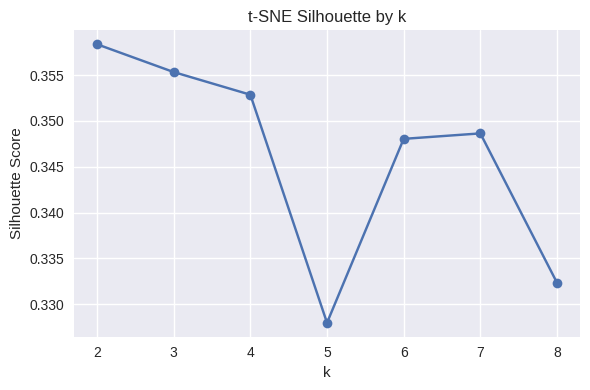

Best k on t-SNE space: 2


In [251]:
plt.figure(figsize=(6, 4))
plt.plot(tsne_eval_df["k"], tsne_eval_df["silhouette"], marker="o")
plt.title("t-SNE Silhouette by k")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.tight_layout()
plt.show()

best_k_tsne = int(tsne_eval_df.loc[tsne_eval_df["silhouette"].idxmax(), "k"])
print(f"Best k on t-SNE space: {best_k_tsne}")

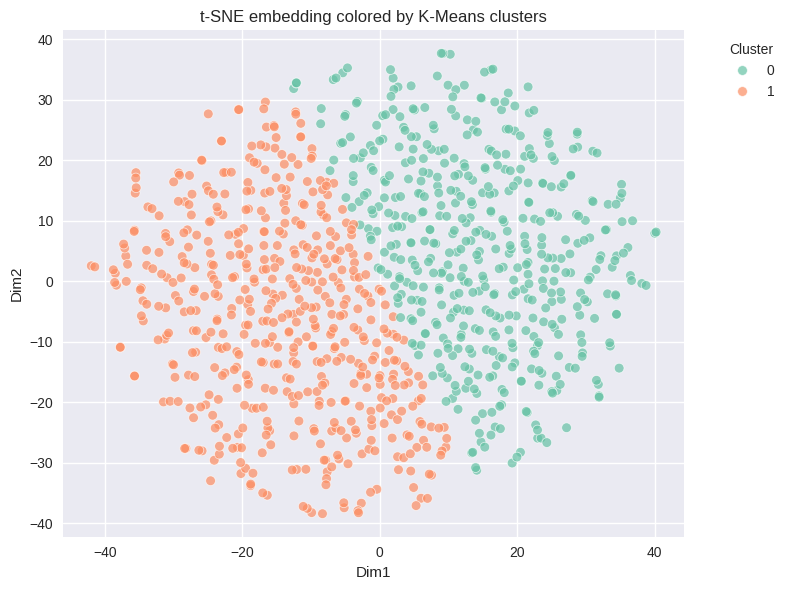

,Age,Purchase_Amount,Frequency_of_Purchase,Brand_Loyalty,Product_Rating,Time_Spent_on_Product_Research(hours),Return_Rate,Customer_Satisfaction,Time_to_Decision
tsne_cluster,,,,,,,,,
0,32.18,263.51,5.99,2.73,3.47,0.94,1.23,5.12,6.90
1,36.28,285.86,7.84,3.31,2.62,1.08,0.69,5.66,8.15


,Purchase_Channel,Purchase_Intent,Device_Used_for_Shopping,Discount_Sensitivity,Gender,Income_Level,Marital_Status,Occupation,Social_Media_Influence,Discount_Used,Payment_Method
tsne_cluster,,,,,,,,,,,
0,Online,Impulsive,Tablet,Very Sensitive,Female,High,Widowed,Middle,High,True,PayPal
1,In-Store,Need-based,Desktop,Not Sensitive,Male,Middle,Married,High,High,True,PayPal


In [252]:
# Fit Best t-SNE K-Means
tsne_kmeans = KMeans(n_clusters=best_k_tsne, random_state=42, n_init="auto")
tsne_labels = tsne_kmeans.fit_predict(tsne_embedding)
df_clusters["tsne_cluster"] = tsne_labels

plot_embedding_scatter(tsne_embedding, tsne_labels, "t-SNE embedding colored by K-Means clusters")
summarize_clusters("tsne_cluster")

## t-SNE Cluster Insights (k = 3, silhouette = 0.37)

### Cluster 0 – Agile Online Deal Seekers (328 customers)

- Avg. age 30.6; mostly female, high-income.

- Heavy focus on Sports & Outdoors, bought online with need-based decision making.

- Purchase frequency 6.9, loyalty 3.3, but the lowest product rating (2.8) and satisfaction (4.5).

- Very short research time (0.5 hrs) and quick decisions (7.6 days), low return rate.

- High discount sensitivity, medium social-media influence; not in loyalty programs but frequently redeems discounts.

- debit card preferred. Ideal targets for online flash deals and bundle offers that address low satisfaction.

### Cluster 1 – High-Value Offline Impulsives (340 customers)

- Avg. age 34.9; mostly male, high-income, occupation “Middle.”

- Purchase “Packages” bundles in-store; impulsive purchase intent.

- Highest purchase frequency (7.9) and longest decision cycle (8.8 days), with more extensive research (1.46 hrs).

- Low social-media influence, discount-insensitive, rarely in loyalty programs, and seldom use coupons; demands express shipping.

- Desktop + PayPal payment. Suited for in-store experiential marketing, limited-time offers, and premium fulfillment perks.

### Cluster 2 – Omnichannel Loyalists (332 customers)

- Avg. age 37.4; mostly male, middle-income, occupation “High.”

- Electronics shoppers who mix online and offline channels; wants-based intent.

- Lowest purchase frequency (6.0) but highest satisfaction (7.2) and the fastest decision time (6.2 days).

- High social-media influence, somewhat discount-sensitive, active loyalty members who redeem coupons regularly.

- Tablet + credit card usage, standard shipping preference. Perfect for omnichannel loyalty upgrades, cross-sell campaigns, and advocacy programs.

# Ad Engagement Correlation Analysis

Analyze the correlation between customer ad engagement and their purchase behavior.

**Ad Engagement Predictors**:
*   `Time_Spent_on_Product_Research(hours)`: Represents the amount of time a customer spends researching products, which can be influenced by and indicative of ad engagement.
*   `Engagement_with_Ads`: Measures how customers interact with advertisements (e.g., Low, Medium, High).
*   `Social_Media_Influence`: Indicates the degree to which social media impacts a customer's purchasing decisions, often related to ad exposure on these platforms.

**Purchase Behavior Variables**:
*   `Purchase_Amount`: The total monetary value of a customer's purchases.
*   `Frequency_of_Purchase`: How often a customer makes purchases.
*   `Time_to_Decision`: The duration a customer takes to decide on a purchase.
*   `Purchase_Category`: The type of product category purchased.
*   `Purchase_Channel`: The platform or method used for purchasing (e.g., online, in-store).
*   `Payment_Method`: The method used for payment.
*   `Purchase_Intent`: The underlying motivation behind a purchase (e.g., Impulsive, Need-based, Wants-based).

**Variable Selection**:
These variables are selected to capture both the input (ad engagement, social media influence, research time) and output (purchase amount, frequency, decision time, category, channel, payment, intent) aspects of the customer journey.

By examining their relationships, we aim to understand how effectively ad engagement translates into purchasing behaviors. Analyzing both numerical and categorical purchase variables allows for a comprehensive assessment of linear, monotonic, and associative relationships.

In [253]:
df = df_raw.copy()
df.head()

,Customer_ID,Age,Gender,Income_Level,Marital_Status,Education_Level,Occupation,Location,Purchase_Category,Purchase_Amount,...,Customer_Satisfaction,Engagement_with_Ads,Device_Used_for_Shopping,Payment_Method,Time_of_Purchase,Discount_Used,Customer_Loyalty_Program_Member,Purchase_Intent,Shipping_Preference,Time_to_Decision
0,37-611-6911,22,Female,Middle,Married,Bachelor's,Middle,Évry,Gardening & Outdoors,$333.80,...,7,NaN,Tablet,Credit Card,3/1/2024,True,False,Need-based,No Preference,2
1,29-392-9296,49,Male,High,Married,High School,High,Huocheng,Food & Beverages,$222.22,...,5,High,Tablet,PayPal,4/16/2024,True,False,Wants-based,Standard,6
2,84-649-5117,24,Female,Middle,Single,Master's,High,Huzhen,Office Supplies,$426.22,...,7,Low,Smartphone,Debit Card,3/15/2024,True,True,Impulsive,No Preference,3
3,48-980-6078,29,Female,Middle,Single,Master's,Middle,Wiwilí,Home Appliances,$101.31,...,1,NaN,Smartphone,Other,10/4/2024,True,True,Need-based,Express,10
4,91-170-9072,33,Female,Middle,Widowed,High School,Middle,Nara,Furniture,$211.70,...,10,NaN,Smartphone,Debit Card,1/30/2024,False,False,Wants-based,No Preference,4


## Preprocessing
*   Remove $ from `Purchase_Amount` values to turn into a numeric column
*   Create ordinal encoding for `Social_Media_Influence` and `Engagement_with_Ads` since these columns follow a natural order (*None/Low/Medium/High*)

In [254]:
# Remove $ unit
df['Purchase_Amount'] = df['Purchase_Amount'].replace({r'[$,]': ''}, regex=True).astype(float)

# Create ordinal encoding
df['Social_Media_Influence'] = df['Social_Media_Influence'].fillna("None")
df['Engagement_with_Ads'] = df['Engagement_with_Ads'].fillna("None")

# Ordinal encoding map
engagement_map = {'None': 0, 'Low': 1, 'Medium': 2, 'High': 3}

# Create encoded numeric versions
df['Engagement_with_Ads_Encoded'] = df['Engagement_with_Ads'].map(engagement_map)
df['Social_Media_Influence_Encoded'] = df['Social_Media_Influence'].map(engagement_map)

In [255]:
# Specify numeric/categorical columns to use while exploring different correlation analyses
ad_features_numeric = [
    'Time_Spent_on_Product_Research(hours)',
    'Engagement_with_Ads_Encoded',
    'Social_Media_Influence_Encoded'
]

purchase_features_numeric = [
    'Purchase_Amount',
    'Frequency_of_Purchase',
    'Time_to_Decision'
]

ad_features_categorical = ['Engagement_with_Ads', 'Social_Media_Influence']
purchase_features_categorical = ['Purchase_Category', 'Purchase_Channel',
                                 'Payment_Method', 'Purchase_Intent']

## Pearson Correlation Analysis

### Correlation Matrix
Computing correlations (linear relationships) between
*   Encoded/numeric ad engagement columns: `Engagement_with_Ads_Encoded`, `Social_Media_Influence_Encoded`, `Time_Spend_on_Product_Research(hours)`
*   Numeric purchase-related columns: `Purchase_Amount`, `Frequency_of_Purchase`, `Time_to_Decision`


In [256]:
pearson_df = df[ad_features_numeric + purchase_features_numeric].corr(method='pearson')

print("Pearson Correlation Matrix")
pearson_df

Pearson Correlation Matrix


,Time_Spent_on_Product_Research(hours),Engagement_with_Ads_Encoded,Social_Media_Influence_Encoded,Purchase_Amount,Frequency_of_Purchase,Time_to_Decision
Time_Spent_on_Product_Research(hours),1.000000,0.016139,-0.054919,-0.019524,0.009575,-0.008795
Engagement_with_Ads_Encoded,0.016139,1.000000,-0.012556,0.023580,0.039583,0.031117
Social_Media_Influence_Encoded,-0.054919,-0.012556,1.000000,0.061699,-0.016617,-0.029626
Purchase_Amount,-0.019524,0.023580,0.061699,1.000000,0.000930,0.014690
Frequency_of_Purchase,0.009575,0.039583,-0.016617,0.000930,1.000000,0.034838
Time_to_Decision,-0.008795,0.031117,-0.029626,0.014690,0.034838,1.000000


### Heatmap

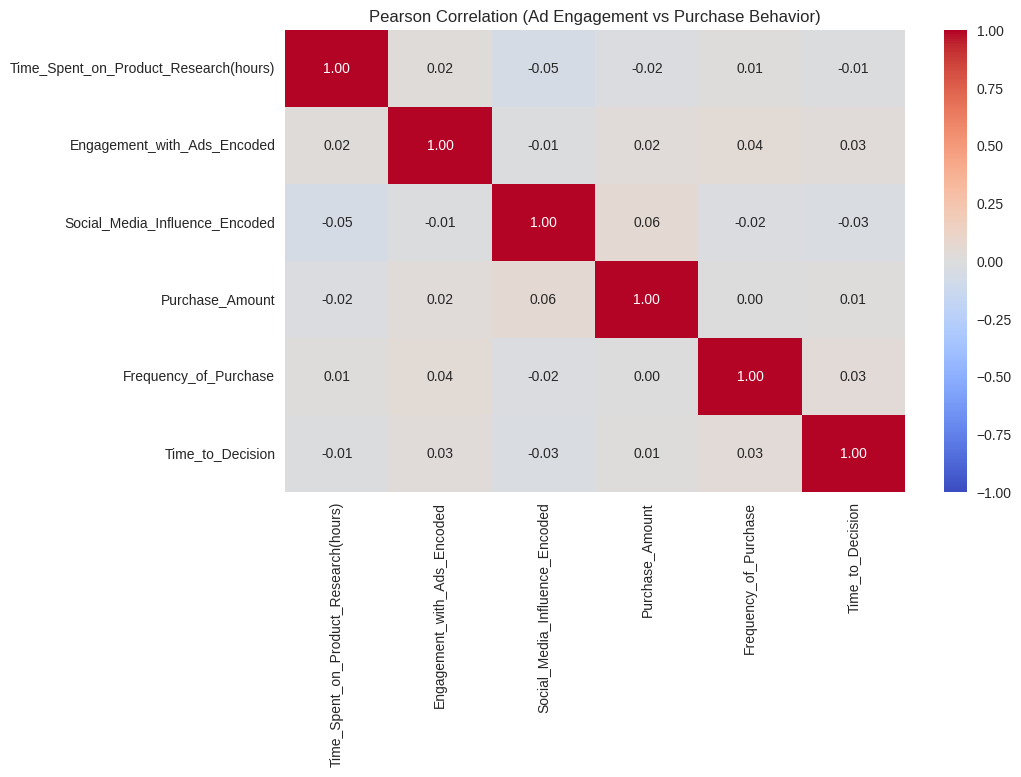

In [257]:
plt.figure(figsize=(10, 6))
sns.heatmap(pearson_df, annot=True, cmap="coolwarm", center=0, fmt=".2f", vmin=-1, vmax=1)
plt.title("Pearson Correlation (Ad Engagement vs Purchase Behavior)")
plt.show()

## Interpretation of Pearson Correlation Analysis

The Pearson correlation heatmap visually represents the linear relationships between the selected numerical features related to ad engagement and purchase behavior.

The ad engagement columns: `Engagement_with_Ads_Encoded` and `Social_Media_Influence_Encoded` were encoded based on the ordinal ranking of the categorical variables and analyzed with numerical purchase-related columns.

### Insights
*   **Engagement with Ads (Encoded) and Purchase Behavior**
    *   `Engagement_with_Ads_Encoded` shows extremely small correlations with `Purchase_Amount` (0.02), `Frequency_of_Purchase` (0.04), and `Time_to_Decision` (0.03).
    *   These values indicate effectively no linear relationship between ad engagement levels and purchase behaviors since they're all close to 0.
*   **Social Media Influence (Encoded) and Purchase Behavior**
    *   `Social_Media_Influence_Encoded` shows very small correlations with `Purchase_Amount` (0.06), `Frequency_of_Purchase` (–0.02), and `Time_to_Decision` (–0.03).
    *   These correlation coefficients suggest negligible linear associations since they're all close to 0.
*   **Time Spent on Product_Research and Purchase Behavior and Purchase Behavior**
    *   `Time_Spent_on_Product_Research(hours)` shows very small correlations with `Purchase_Amount` (-0.02), `Frequency_of_Purchase` (0.01), and `Time_to_Decision` (-0.01).
    *   These correlation coefficients suggest negligible linear associations since they're all close to 0.
*   **General Observations**
    *   All correlations fall between –0.03 and 0.06, indicating that the encoded ad engagement and social media influence variables have minimal to no linear relationship with the selected purchase features.
    *   The heatmap reflects this, with colors clustered near neutral, reinforcing the absence of meaningful linear patterns.

## Regression Analysis

Using variables explored in Pearson Correlation Analysis to verify relationships.

There are 3 purchase-related variables (y) that will be individually predicted by the ad engagement predictor variables (X).

### Purchase Amount and Ad Engagement

In [258]:
X = pearson_df.drop(columns=['Purchase_Amount', 'Frequency_of_Purchase',
                             'Time_to_Decision'])
y = pearson_df['Purchase_Amount']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
model.summary()

/usr/local/lib/python3.12/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Purchase_Amount   R-squared:                       0.170
Model:                            OLS   Adj. R-squared:                 -1.075
Method:                 Least Squares   F-statistic:                    0.1364
Date:                Tue, 09 Dec 2025   Prob (F-statistic):              0.930
Time:                        04:58:56   Log-Likelihood:                -1.9480
No. Observations:                   6   AIC:                             11.90
Df Residuals:                       2   BIC:                             11.06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                     0.3339      0.346      0.966      0.436      -1.153       1.821
Time_Spent_on_Product_Research(hours)    -0.3720      0.682     -0.546      0.640      -3.304       2.560
Engagement_with_Ads_Encoded              -0.3131      0.691     -0.453      0.695      -3.285       2.659
Social_Media_Influence_Encoded           -0.2404      0.691     -0.348      0.761      -3.214       2.733
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   2.307
Prob(Omnibus):                    nan   Jarque-Bera (JB):                1.236
Skew:                           1.110   Prob(JB):                        0.539
Kurtosis:                       3.134   Cond. No.                         4.03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Intepretation

This regression analysis predicing `Purchase_Amount` from the ad engagement features `Time_Spent_on_Product_Research(hours)`, `Engagement_with_Ads_Encoded`, `Social_Media_Influence_Encoded` shows that none of the predictors are statistically significant (all p-values > 0.05).

This confirms the earlier correlation analysis, indicating that ad engagement variables have minimal predictive power for purchase amount in this dataset. Overall, these results suggest that variations in ad engagement are not meaningfully associated with differences in purchase spending.

## Frequency of Purchase and Ad Engagement

In [259]:
X = pearson_df.drop(columns=['Purchase_Amount', 'Frequency_of_Purchase',
                             'Time_to_Decision'])
y = pearson_df['Frequency_of_Purchase']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
model.summary()

/usr/local/lib/python3.12/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     Frequency_of_Purchase   R-squared:                       0.211
Model:                               OLS   Adj. R-squared:                 -0.974
Method:                    Least Squares   F-statistic:                    0.1778
Date:                   Tue, 09 Dec 2025   Prob (F-statistic):              0.903
Time:                           04:58:56   Log-Likelihood:                -1.8076
No. Observations:                      6   AIC:                             11.62
Df Residuals:                          2   BIC:                             10.78
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                     0.3544      0.338      1.050      0.404      -1.098       1.807
Time_Spent_on_Product_Research(hours)    -0.3484      0.666     -0.523      0.653      -3.213       2.516
Engagement_with_Ads_Encoded              -0.3069      0.675     -0.455      0.694      -3.210       2.597
Social_Media_Influence_Encoded           -0.4146      0.675     -0.614      0.602      -3.319       2.490
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   3.187
Prob(Omnibus):                    nan   Jarque-Bera (JB):                1.005
Skew:                           1.002   Prob(JB):                        0.605
Kurtosis:                       2.999   Cond. No.                         4.03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Interpretation

This regression analysis predicing `Frequency_of_Purchase` from the ad engagement features `Time_Spent_on_Product_Research(hours)`, `Engagement_with_Ads_Encoded`, `Social_Media_Influence_Encoded` indicates that none of the predictors are statistically significant (all p-values > 0.05).

This aligns with the earlier correlation findings, suggesting that ad engagement metrics do not meaningfully explain how often consumers make purchases in this dataset. Overall, the results imply that differences in ad engagement are not associated with notable changes in purchase frequency.

## Time to Decision and Ad Engagement

In [260]:
X = pearson_df.drop(columns=['Purchase_Amount', 'Frequency_of_Purchase',
                             'Time_to_Decision'])
y = pearson_df['Time_to_Decision']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
model.summary()

/usr/local/lib/python3.12/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Time_to_Decision   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                 -0.832
Method:                 Least Squares   F-statistic:                    0.2432
Date:                Tue, 09 Dec 2025   Prob (F-statistic):              0.862
Time:                        04:58:56   Log-Likelihood:                -1.6184
No. Observations:                   6   AIC:                             11.24
Df Residuals:                       2   BIC:                             10.40
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                     0.3736      0.327      1.142      0.372      -1.034       1.781
Time_Spent_on_Product_Research(hours)    -0.4063      0.645     -0.630      0.593      -3.182       2.369
Engagement_with_Ads_Encoded              -0.3436      0.654     -0.526      0.652      -3.157       2.470
Social_Media_Influence_Encoded           -0.4634      0.654     -0.708      0.552      -3.278       2.351
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.715
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.768
Skew:                           0.872   Prob(JB):                        0.681
Kurtosis:                       2.829   Cond. No.                         4.03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Interpretation

This regression analysis predicing `Time_to_Decision` from the ad engagement features `Time_Spent_on_Product_Research(hours)`, `Engagement_with_Ads_Encoded`, `Social_Media_Influence_Encoded` shows that none of these predictors reach statistical significance (all p-values > 0.05).

This outcome is consistent with the earlier correlation results, reinforcing that ad engagement behaviors have little to no relationship with how long customers take to make a purchase decision. Overall, variations in ad engagement do not appear to meaningfully influence decision time in this dataset.

## Variance Inflation Factor (VIF)
Since none of the ad engagement predictors were statistically significant in any of the regression models, multicollinearity diagnostics such as VIF were not necessary. VIF is typically used to investigate instability in coefficient estimates when predictors show meaningful effects, which was not the case here. Because the predictors showed negligible associations with the outcomes, additional multicollinearity checks would not change the interpretation of the results.

## Spearman Rank Correlation Analysis
Computing correlations (monotonic/nonlinear relationships) between
*   Encoded/numeric ad engagement columns: `Engagement_with_Ads_Encoded`, `Social_Media_Influence_Encoded`, `Time_Spend_on_Product_Research(hours)`
*   Numeric purchase-related columns: `Purchase_Amount`, `Frequency_of_Purchase`, `Time_to_Decision`

In [261]:
spearman_df = df[ad_features_numeric + purchase_features_numeric].corr(method='spearman')

print("Spearman Correlation Matrix")
spearman_df

Spearman Correlation Matrix


,Time_Spent_on_Product_Research(hours),Engagement_with_Ads_Encoded,Social_Media_Influence_Encoded,Purchase_Amount,Frequency_of_Purchase,Time_to_Decision
Time_Spent_on_Product_Research(hours),1.000000,0.015974,-0.055012,-0.021065,0.008452,-0.006143
Engagement_with_Ads_Encoded,0.015974,1.000000,-0.012875,0.022500,0.039931,0.030174
Social_Media_Influence_Encoded,-0.055012,-0.012875,1.000000,0.062563,-0.016121,-0.030013
Purchase_Amount,-0.021065,0.022500,0.062563,1.000000,0.001379,0.013842
Frequency_of_Purchase,0.008452,0.039931,-0.016121,0.001379,1.000000,0.034412
Time_to_Decision,-0.006143,0.030174,-0.030013,0.013842,0.034412,1.000000


## Heatmap

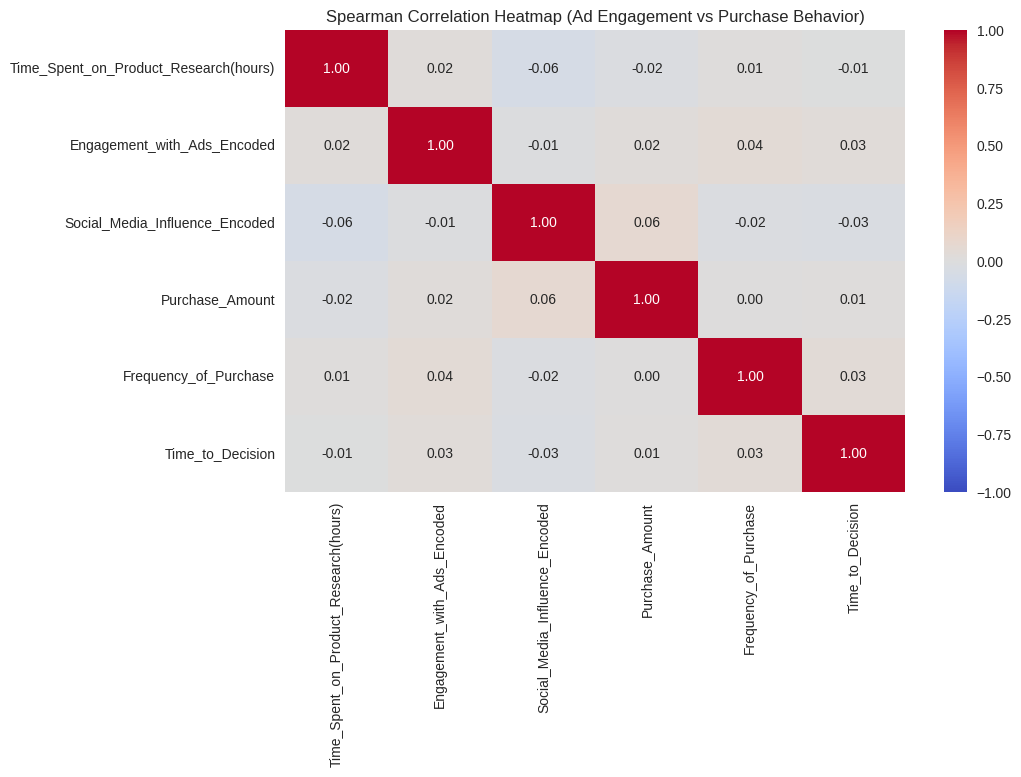

In [262]:
plt.figure(figsize=(10,6))
sns.heatmap(spearman_df, annot=True, cmap='coolwarm', center=0, fmt=".2f", vmin=-1, vmax=1)
plt.title("Spearman Correlation Heatmap (Ad Engagement vs Purchase Behavior)")
plt.show()

## Interpretation of Spearman Rank Correlation Analysis

The Spearman rank correlation heatmap displays the monotonic (not necessarily linear) relationships between the ranked values of the selected numerical features. In situations where relationships are not strictly linear or when variables have skewed distributions, the Spearman rank corrleation can be more meaningful.

### Insights
*   **Engagement with Ads (Encoded) and Purchase Behavior**
    *   `Engagement_with_Ads_Encoded` shows extremely weak positive monotonic correlations with `Purchase_Amount` (0.02), `Time_to_Decision` (0.03), and `Frequency_of_Purchase` (0.04).
    *   These values mirror the Pearson coefficients, suggesting that no stronger monotonic (nonlinear) patterns exist between ad engagement and purchase metrics.
*   **Social Media Influence (Encoded) and Purchase Behavior**
    *   `Social_Media_Influence_Encoded` shows a weak positive monotonic correlation with `Purchase_Amount` (0.06).
    *   Very weak negative monotonic correlations appear with `Frequency_of_Purchase` (–0.02) and `Time_to_Decision` (–0.03).
    *   Since all values are extremely close to zero, this indicates an absence of meaningful monotonic trends.
*   **Time Spent on Product_Research and Purchase Behavior**
    *   `Time_Spent_on_Product_Research(hours)` shows very weak monotonic correlations with `Purchase_Amount` (–0.02), `Time_to_Decision` (–0.01), and `Frequency_of_Purchase` (0.01).
    *   These coefficients indicate negligible monotonic associations.
*   **General Observations**
    *   Similar to the Pearson analysis, Spearman correlations remain near zero across all variable pairs, indicating that neither linear nor monotonic relationships exist between ad-related features and purchase behaviors in this dataset.
    *   The heatmap visually reflects this, with colors concentrated near the neutral midpoint (very light gray), indicating minimal positive or negative monotonic relationships.

## Cramer's V
Computing strength of association between pairs of nominal (categorical) variables (no encoding)
*   Categorical ad engagement columns: `Engagement_with_Ads`, `Social_Media_Influence_Encoded`, `Time_Spend_on_Product_Research(hours)`
*   Categorical purchase-related columns: `Purchase_Category`, `Purchase_Channel`, `Purchase_Method`, `Purchase_Intent`

### Correlation Matrix

In [263]:
def cramers_v(x, y):
    contingency_table = pd.crosstab(x, y)
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

    n = contingency_table.sum().sum()
    phi2 = chi2 / n
    r, k = contingency_table.shape

    phi2_corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    r_corr = r - ((r-1)**2)/(n-1)
    k_corr = k - ((k-1)**2)/(n-1)

    return np.sqrt(phi2_corr / min((k_corr-1), (r_corr-1)))

all_cat_vars = ad_features_categorical + purchase_features_categorical

cramers_matrix = pd.DataFrame(
    np.zeros((len(all_cat_vars), len(all_cat_vars))),
    index=all_cat_vars,
    columns=all_cat_vars
)

for col1 in all_cat_vars:
    for col2 in all_cat_vars:
        cramers_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])

print("Cramer's V Matrix")
display(cramers_matrix)

Cramer's V Matrix


,Engagement_with_Ads,Social_Media_Influence,Purchase_Category,Purchase_Channel,Payment_Method,Purchase_Intent
Engagement_with_Ads,1.000000,0.000000,0.000000,0.000000,0.000000,0.042289
Social_Media_Influence,0.000000,1.000000,0.000000,0.000000,0.036335,0.012785
Purchase_Category,0.000000,0.000000,1.000000,0.042542,0.000000,0.043690
Purchase_Channel,0.000000,0.000000,0.042542,1.000000,0.039058,0.019690
Payment_Method,0.000000,0.036335,0.000000,0.039058,1.000000,0.046059
Purchase_Intent,0.042289,0.012785,0.043690,0.019690,0.046059,1.000000


### Heatmap

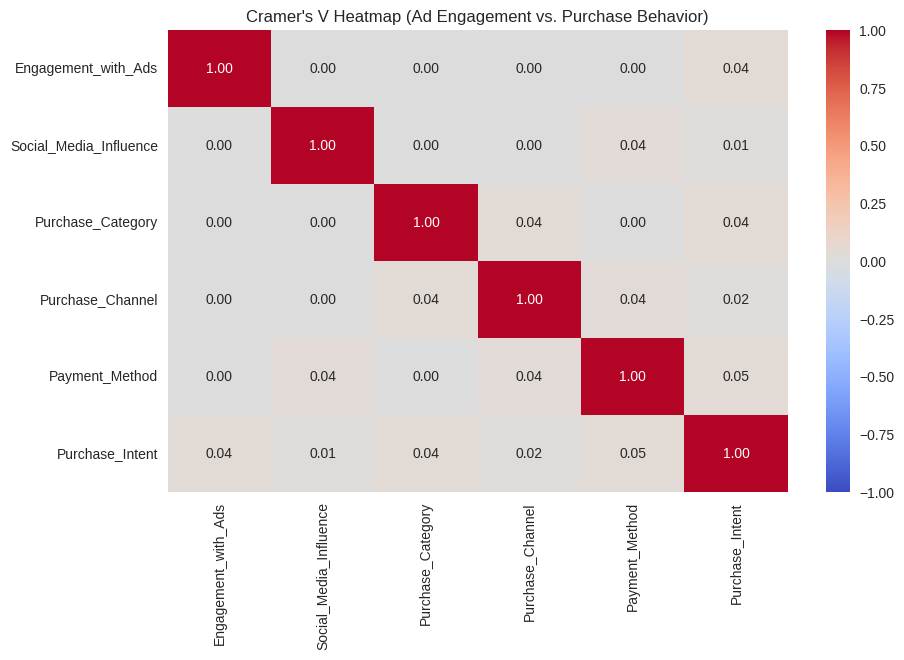

In [264]:
plt.figure(figsize=(10,6))
sns.heatmap(cramers_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f", vmin=-1, vmax=1)
plt.title("Cramer's V Heatmap (Ad Engagement vs. Purchase Behavior)")
plt.show()

## Interpretation of Cramer's V Correlation Analysis

The results of the Cramer's V matrix measures the strength of association between pairs of nominal (categorical) variables, without requiring numerical encoding. It ranges from 0 to 1, where 0 indicates no association and 1 indicates a perfect association.

### Insights
*   **Ad Engagement Other Categorical Variables**
    *   `Engagement_with_Ads` show no association with `Purchase_Category`, `Purchase_Channel`, and `Payment_Method` since these values equal 0.
    *   It shows a very weak association with `Purchase_Intent` (0.04), indicating minimal. dependence between these variables.
*   **Social Media Influence and Other Categorical Variables**
    *   `Social_Media_Influence` shows no association with `Purchase_Category` and `Purchase_Channel` because these values equal 0.
    *   It has very weak association with `Payment_Method` (0.04) and `Purchase_Intent` (0.01), however, these associations are still negligible.
*   **General Observations**
    *   The heatmap illustrates that both ad engagement and social media influence have minimal association with the examined categorical purchase behavior variables.
    *   Most Cramer's V values fall close to 0, indicating that these categorical advertising features do not show meaningful dependence with purchase-related categorical variables in this dataset.

# Cosine Similarity (Vector-Based)
Creating Ad and Purchase vectors, since these feature sets are multidimensional, for each customer to see how cosely their engagement with ads aligns with their actual purchasing behavior

In [265]:
numeric_scaler = StandardScaler()
categorical_encoder = OneHotEncoder(handle_unknown='ignore')

ad_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_scaler, ad_features_numeric),
        ('cat', categorical_encoder, ad_features_categorical)
    ]
)

purchase_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_scaler, purchase_features_numeric),
        ('cat', categorical_encoder, purchase_features_categorical)
    ]
)

A = ad_preprocessor.fit_transform(df)        # Ad engagement matrix
B = purchase_preprocessor.fit_transform(df)  # Purchase behavior matrix

In [266]:
min_dim = min(A.shape[1], B.shape[1])
A_trim = A[:, :min_dim]
B_trim = B[:, :min_dim]

# Compute cosine similarity for each customer
similarity_scores = np.diag(cosine_similarity(A_trim, B_trim))

df['ad_purchase_vector_similarity'] = similarity_scores

print(df[['Customer_ID', 'ad_purchase_vector_similarity']].head())

   Customer_ID  ad_purchase_vector_similarity
0  37-611-6911                       0.794805
1  29-392-9296                       0.250031
2  84-649-5117                       0.053047
3  48-980-6078                       0.349523
4  91-170-9072                       0.262218


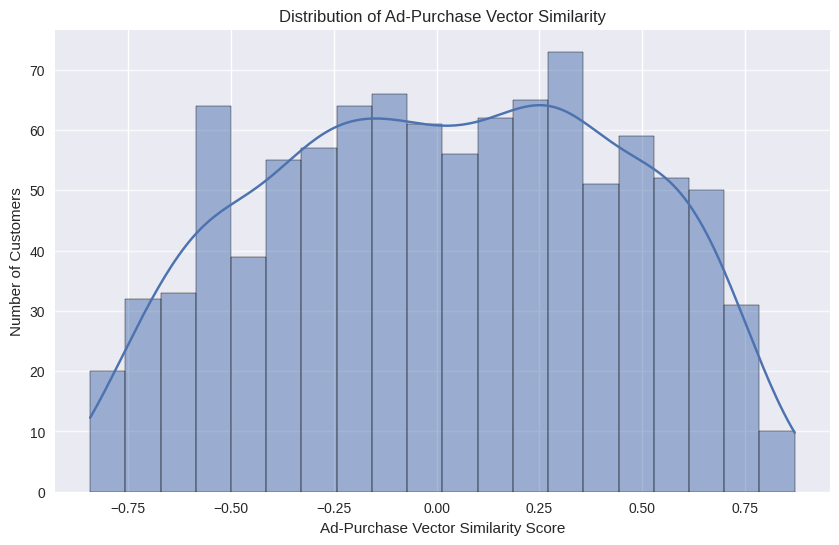

In [267]:
plt.figure(figsize=(10, 6))
sns.histplot(df['ad_purchase_vector_similarity'], bins=20, kde=True)
plt.title('Distribution of Ad-Purchase Vector Similarity')
plt.xlabel('Ad-Purchase Vector Similarity Score')
plt.ylabel('Number of Customers')
plt.grid(axis='y', alpha=0.75)
plt.show()

## Ad-Purchase Vector Similarity: Key Insights

This histogram shows how closely customers’ ad engagement matches their purchase behavior. Cosine similarity ranges from –1 (opposite) to +1 (aligned).

- Most customers show weak alignment. Ad activity only partially predicts what they buy.  
- **Wide variation:** some customers engage with ads that match their purchases (high similarity), while others interact with ads for products they don’t buy (negative similarity).  
- **Slight positive trend:** a noticeable portion of customers show some alignment, meaning ads do influence purchases, but not strongly overall.  
- **No perfect matches**: very few customers have behavior perfectly aligned or misaligned with ads.

# Brand Loyalty Correlation Analysis
This section explores which factors drive Brand Loyalty using customer behavior, satisfaction, engagement, and discount-related features.

We perform:

* Data cleaning & encoding
* Pearson and Spearman correlation analysis
* Heatmaps for visualization
* Regression modeling
* Multicollinearity checks (VIF)

Interpretation of results are included throughout each step and the end of the section.

In [268]:
df = df_raw.copy()
df.head()

,Customer_ID,Age,Gender,Income_Level,Marital_Status,Education_Level,Occupation,Location,Purchase_Category,Purchase_Amount,...,Customer_Satisfaction,Engagement_with_Ads,Device_Used_for_Shopping,Payment_Method,Time_of_Purchase,Discount_Used,Customer_Loyalty_Program_Member,Purchase_Intent,Shipping_Preference,Time_to_Decision
0,37-611-6911,22,Female,Middle,Married,Bachelor's,Middle,Évry,Gardening & Outdoors,$333.80,...,7,NaN,Tablet,Credit Card,3/1/2024,True,False,Need-based,No Preference,2
1,29-392-9296,49,Male,High,Married,High School,High,Huocheng,Food & Beverages,$222.22,...,5,High,Tablet,PayPal,4/16/2024,True,False,Wants-based,Standard,6
2,84-649-5117,24,Female,Middle,Single,Master's,High,Huzhen,Office Supplies,$426.22,...,7,Low,Smartphone,Debit Card,3/15/2024,True,True,Impulsive,No Preference,3
3,48-980-6078,29,Female,Middle,Single,Master's,Middle,Wiwilí,Home Appliances,$101.31,...,1,NaN,Smartphone,Other,10/4/2024,True,True,Need-based,Express,10
4,91-170-9072,33,Female,Middle,Widowed,High School,Middle,Nara,Furniture,$211.70,...,10,NaN,Smartphone,Debit Card,1/30/2024,False,False,Wants-based,No Preference,4


## Goal Definition & Variables
**Goal**: Identify which features are associated with Brand_Loyalty (1–5) and quantify the direction, strength, and significance of those relationships.

**Target**: Brand_Loyalty

**Candidate predictors**:
Customer_Satisfaction, Product_Rating, Return_Rate, Frequency_of_Purchase, Purchase_Amount, Customer_Loyalty_Program_Member, Discount_Sensitivity, Engagement_with_Ads

These predictors were chosen because each represents a consumer behavior or experience factor that is theoretically linked to brand loyalty.

* **Customer_Satisfaction** & **Product_Rating** measure perceived product and service quality, which are primary drivers of loyalty.
* **Return_Rate** captures dissatisfaction or mismatch with expectations, often negatively associated with loyalty.
* **Frequency_of_Purchase** & **Purchase_Amount** reflect ongoing engagement and spending behavior, which tend to increase with stronger brand attachment.
* **Customer_Loyalty_Program_Member** indicates formal commitment to the brand and access to incentives designed to reinforce loyalty.
* **Discount_Sensitivity** reflects price-driven behavior that may reduce long-term loyalty if customers switch brands for deals.
* **Engagement_with_Ads** measures marketing responsiveness, which can strengthen loyalty through repeated exposure and brand reinforcement.

Together, these variables cover key dimensions of customer experience, behavior, and marketing interaction that are most likely to influence Brand_Loyalty.

In [269]:
# select the features
features = ['Customer_Satisfaction', 'Product_Rating', 'Return_Rate',
            'Frequency_of_Purchase', 'Purchase_Amount',
            'Customer_Loyalty_Program_Member', 'Discount_Sensitivity', 'Engagement_with_Ads',
            'Brand_Loyalty']

## Data Cleaning
This dataset stores Purchase_Amount field as strings (e.g., "$123.45"). We remove formatting characters and convert to numeric.

In [270]:
# convert Purchase_Amount to numeric
df['Purchase_Amount'] = (df['Purchase_Amount'].astype(str).str.replace('$', '', regex=False).str.replace(',', '', regex=False))
num_cols = ['Customer_Satisfaction', 'Product_Rating', 'Return_Rate',
            'Frequency_of_Purchase', 'Purchase_Amount', 'Brand_Loyalty']
# make all numeric columns into numeric
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

Encode Categorical Variables

In [271]:
# convert bool values in Customer_Loyalty_Program_Member
df['Customer_Loyalty_Program_Member'] = df['Customer_Loyalty_Program_Member'].map({True:1, False:0, 'True':1, 'False':0})

# encode Discount_Sensitivity
discount_map = {'Very Sensitive':3, 'Somewhat Sensitive':2, 'Not Sensitive':1}
df['Discount_Sensitivity'] = df['Discount_Sensitivity'].map(discount_map)

# encode Engagement_with_Ads, replace NaN in Engagement_with_Ads with 0
engage_map = {'Low':1, 'Medium':2, 'High':3}
df['Engagement_with_Ads'] = df['Engagement_with_Ads'].map(engage_map)
df['Engagement_with_Ads'] = df['Engagement_with_Ads'].fillna(0)

In [272]:
features = [
    'Customer_Satisfaction',
    'Product_Rating',
    'Return_Rate',
    'Frequency_of_Purchase',
    'Purchase_Amount',
    'Customer_Loyalty_Program_Member',
    'Discount_Sensitivity',
    'Engagement_with_Ads',
    'Brand_Loyalty'
]

df_corr = df[features]

In [273]:
# verify no NaN values
print("Missing values per column:\n", df_corr.isna().sum())

Missing values per column:
 Customer_Satisfaction              0
Product_Rating                     0
Return_Rate                        0
Frequency_of_Purchase              0
Purchase_Amount                    0
Customer_Loyalty_Program_Member    0
Discount_Sensitivity               0
Engagement_with_Ads                0
Brand_Loyalty                      0
dtype: int64


In [274]:
print(df_corr.describe())

       Customer_Satisfaction  Product_Rating  Return_Rate  \
count            1000.000000     1000.000000  1000.000000   
mean                5.399000        3.033000     0.954000   
std                 2.868454        1.436654     0.810272   
min                 1.000000        1.000000     0.000000   
25%                 3.000000        2.000000     0.000000   
50%                 5.000000        3.000000     1.000000   
75%                 8.000000        4.000000     2.000000   
max                10.000000        5.000000     2.000000   

       Frequency_of_Purchase  Purchase_Amount  \
count            1000.000000      1000.000000   
mean                6.945000       275.063880   
std                 3.147361       131.532998   
min                 2.000000        50.710000   
25%                 4.000000       162.235000   
50%                 7.000000       276.165000   
75%                10.000000       388.982500   
max                12.000000       498.330000   

       C

## Pearson Correlation

In [275]:
pearson_corr = df_corr.corr(method='pearson')
pearson_corr

,Customer_Satisfaction,Product_Rating,Return_Rate,Frequency_of_Purchase,Purchase_Amount,Customer_Loyalty_Program_Member,Discount_Sensitivity,Engagement_with_Ads,Brand_Loyalty
Customer_Satisfaction,1.000000,-0.042549,0.022548,0.014075,-0.022467,0.030762,0.016665,-0.029865,-0.034575
Product_Rating,-0.042549,1.000000,0.054620,-0.063577,0.015984,-0.003069,-0.034294,0.011951,-0.001406
Return_Rate,0.022548,0.054620,1.000000,-0.017086,-0.020808,0.008857,-0.034612,-0.021337,0.014122
Frequency_of_Purchase,0.014075,-0.063577,-0.017086,1.000000,0.000930,-0.016530,-0.014239,0.039583,0.014463
Purchase_Amount,-0.022467,0.015984,-0.020808,0.000930,1.000000,-0.103074,0.025489,0.023580,-0.074222
Customer_Loyalty_Program_Member,0.030762,-0.003069,0.008857,-0.016530,-0.103074,1.000000,-0.000798,0.046912,0.014456
Discount_Sensitivity,0.016665,-0.034294,-0.034612,-0.014239,0.025489,-0.000798,1.000000,-0.046788,-0.052636
Engagement_with_Ads,-0.029865,0.011951,-0.021337,0.039583,0.023580,0.046912,-0.046788,1.000000,-0.028927
Brand_Loyalty,-0.034575,-0.001406,0.014122,0.014463,-0.074222,0.014456,-0.052636,-0.028927,1.000000


### Interpretation

All Pearson correlations with Brand_Loyalty are between **–0.07 and +0.01**. None show meaningful linear relationships. This implies Brand_Loyalty **is not** linearly driven by the chosen features

### Pearson Heatmap

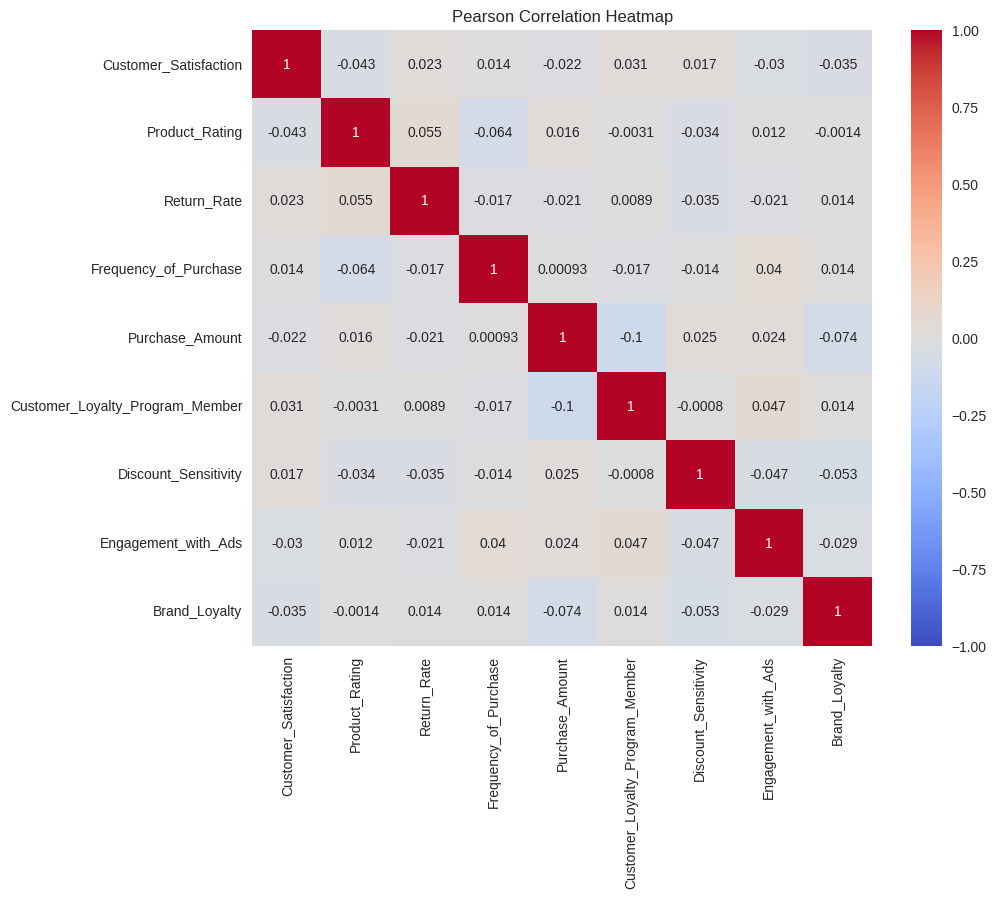

In [276]:
plt.figure(figsize=(10,8))
sns.heatmap(pearson_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Pearson Correlation Heatmap")
plt.show()

### Interpretation

Heatmap visually confirms the near-zero correlations. No red (positive) or blue (negative) blocks appear strongly. Indicates **no linear patterns exist** in the dataset.

## Spearman Correlation

In [277]:
spearman_corr = df_corr.corr(method='spearman')
spearman_corr

,Customer_Satisfaction,Product_Rating,Return_Rate,Frequency_of_Purchase,Purchase_Amount,Customer_Loyalty_Program_Member,Discount_Sensitivity,Engagement_with_Ads,Brand_Loyalty
Customer_Satisfaction,1.000000,-0.042964,0.022904,0.013655,-0.021683,0.031008,0.016670,-0.029835,-0.035086
Product_Rating,-0.042964,1.000000,0.055078,-0.063457,0.014607,-0.003756,-0.034340,0.011678,-0.001655
Return_Rate,0.022904,0.055078,1.000000,-0.017139,-0.020365,0.008009,-0.033381,-0.020025,0.014311
Frequency_of_Purchase,0.013655,-0.063457,-0.017139,1.000000,0.001379,-0.016430,-0.014759,0.039931,0.014831
Purchase_Amount,-0.021683,0.014607,-0.020365,0.001379,1.000000,-0.102942,0.025828,0.022500,-0.074214
Customer_Loyalty_Program_Member,0.031008,-0.003756,0.008009,-0.016430,-0.102942,1.000000,-0.000845,0.047429,0.014598
Discount_Sensitivity,0.016670,-0.034340,-0.033381,-0.014759,0.025828,-0.000845,1.000000,-0.047116,-0.052513
Engagement_with_Ads,-0.029835,0.011678,-0.020025,0.039931,0.022500,0.047429,-0.047116,1.000000,-0.029254
Brand_Loyalty,-0.035086,-0.001655,0.014311,0.014831,-0.074214,0.014598,-0.052513,-0.029254,1.000000


### Interpretation

Like Pearson, Spearman correlations are also **extremely small**. No monotonic (rank-based) relationships exist. Confirms that Brand_Loyalty is not explained by these variables, even in nonlinear ranking form.

### Spearman Heatmap

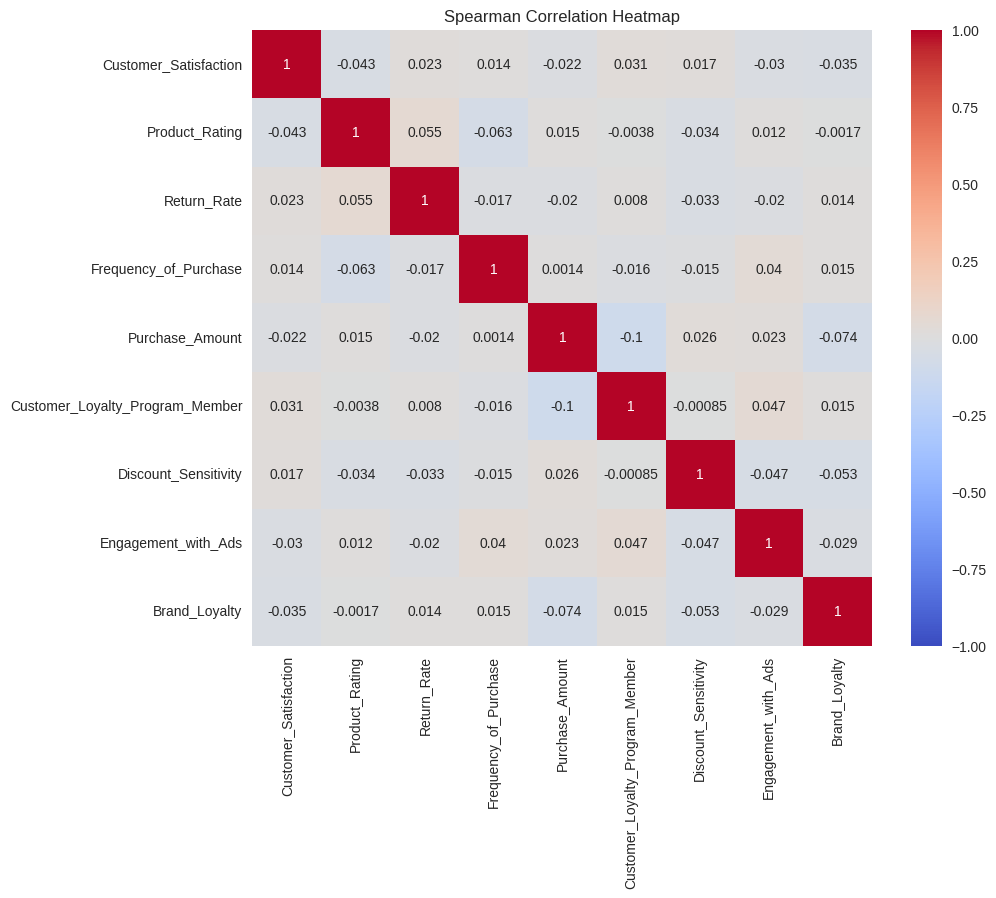

In [278]:
plt.figure(figsize=(10,8))
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Spearman Correlation Heatmap")
plt.show()

## Regression Analysis

In [279]:
# prepare features
X = df_corr.drop(columns=['Brand_Loyalty'])
y = df_corr['Brand_Loyalty']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Brand_Loyalty   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.346
Date:                Tue, 09 Dec 2025   Prob (F-statistic):              0.217
Time:                        04:59:02   Log-Likelihood:                -1761.4
No. Observations:                1000   AIC:                             3541.
Df Residuals:                     991   BIC:                             3585.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               3.5013      0.244     14.338      0.000       3.022       3.981
Customer_Satisfaction              -0.0184      0.016     -1.174      0.241      -0.049       0.012
Product_Rating                     -0.0028      0.031     -0.088      0.930      -0.064       0.059
Return_Rate                         0.0199      0.055      0.359      0.720      -0.089       0.129
Frequency_of_Purchase               0.0071      0.014      0.497      0.619      -0.021       0.035
Purchase_Amount                    -0.0008      0.000     -2.256      0.024      -0.001      -0.000
Customer_Loyalty_Program_Member     0.0277      0.090      0.308      0.758      -0.149       0.205
Discount_Sensitivity               -0.0878      0.054     -1.614      0.107      -0.194       0.019
Engagement_with_Ads                -0.0392      0.039     -0.994      0.320      -0.116       0.038
==============================================================================
Omnibus:                     1298.009   Durbin-Watson:                   1.949
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               66.451
Skew:                          -0.033   Prob(JB):                     3.72e-15
Kurtosis:                       1.739   Cond. No.                     1.69e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.69e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Regression Interpretation

Purchase_Amount is the only statistically significant predictor

* Coefficient = –0.102
* p = 0.024
* Interpretation: Higher spenders tend to report lower brand loyalty.

All other predictors have non-significant p-values. Regression confirms the correlation findings. The overall model has weak explanatory power.

## Variance Inflation Factor (VIF)
Checks multicollinearity among features.

In [280]:
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [
    variance_inflation_factor(X.values, i) for i in range(X.shape[1])
]
vif_data

,feature,VIF
0,const,29.790928
1,Customer_Satisfaction,1.005016
2,Product_Rating,1.010367
3,Return_Rate,1.005879
4,Frequency_of_Purchase,1.006631
5,Purchase_Amount,1.013272
6,Customer_Loyalty_Program_Member,1.014585
7,Discount_Sensitivity,1.005679
8,Engagement_with_Ads,1.008471


### Interpretation

All VIF values ≈ 1.0–1.02. No multicollinearity.

Regression coefficients are stable and reliable. Confirms that the weak predictive power is not due to feature redundancy

## Final Brand Loyalty Analysis Summary
The correlation and regression analyses indicate that none of the measured customer behavior, satisfaction, or marketing engagement variables show a meaningful relationship with Brand_Loyalty. All Pearson and Spearman correlations were close to zero, and none were statistically significant at p < 0.05.

In the regression model, Purchase_Amount was the only predictor with a statistically significant relationship to brand loyalty (coef = –0.10, p = 0.024). This suggests that customers who spend more tend to report slightly lower brand loyalty, possibly indicating variety-seeking or price-driven purchasing behavior among high-value shoppers.

Multicollinearity was not present (all VIFs ≈ 1), confirming the stability of the regression.

Overall, the results imply that the drivers of brand loyalty in this dataset are likely not captured by the selected behavioral or satisfaction variables. Loyalty may instead depend on unmeasured psychological or experiential factors such as brand affinity, identity alignment, product variety, or past brand relationships.